In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 3
NUM_CLASSES = 3
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Datasets/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

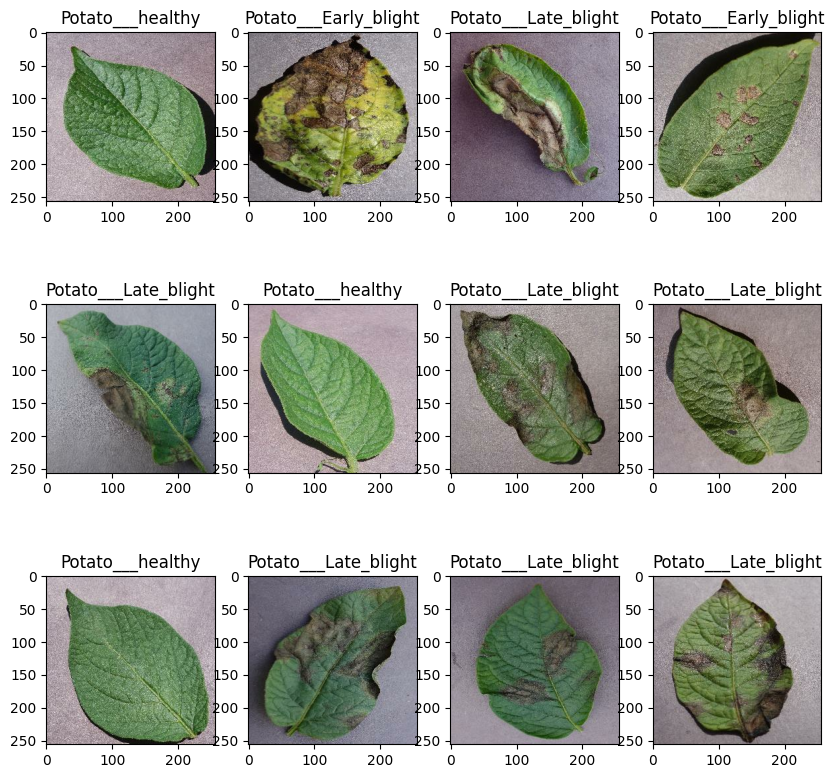

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
  # print(image_batch[0].shape)
  # print(label_batch.numpy())

Preparing train and test datasets

In [7]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds = dataset.take(54)
len(train_ds)

54

In [9]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [10]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [11]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

Preprocessing images

In [14]:
rescale_resize = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

Building Model

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    rescale_resize,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

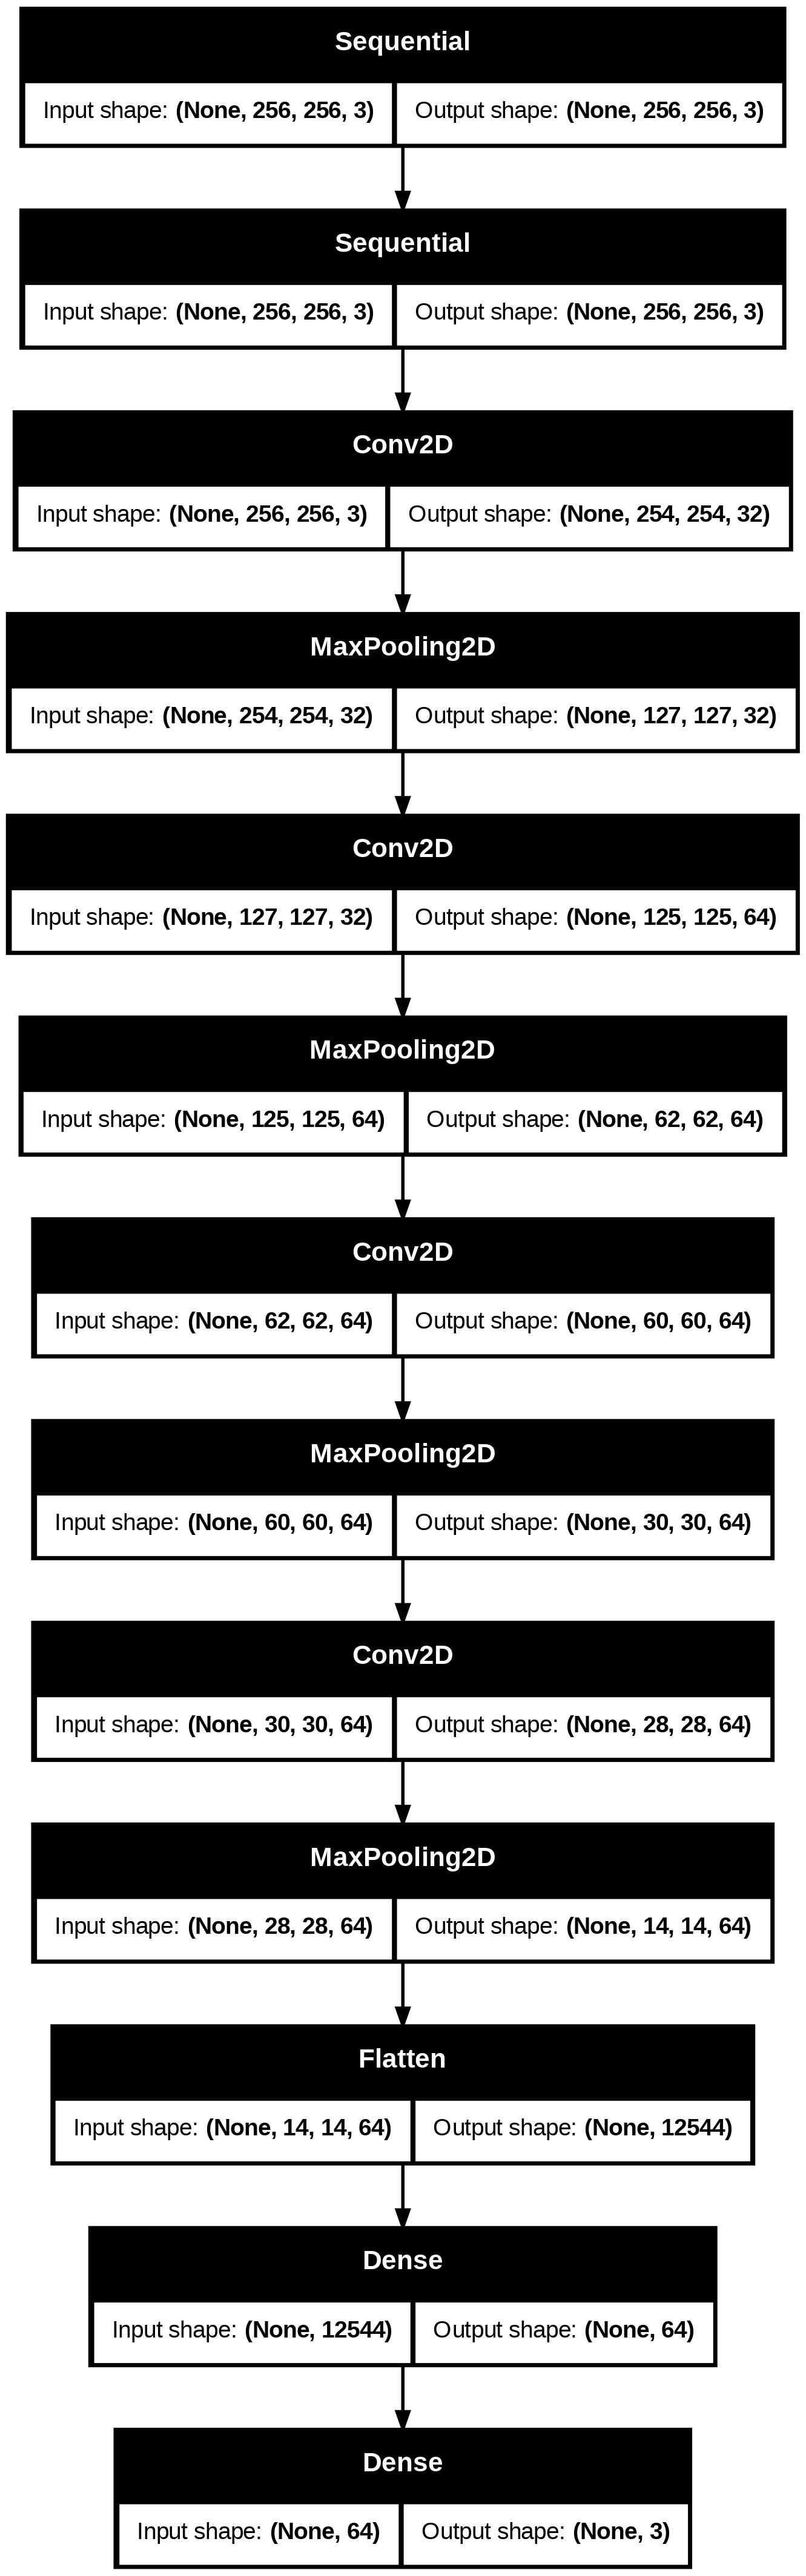

In [50]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    epochs = EPOCHS,
    verbose = 1
)


Epoch 1/3
54/54 ━━━━━━━━━━━━━━━━━━━━ 162s 501ms/step - accuracy: 0.4985 - loss: 0.9078 - val_accuracy: 0.8438 - val_loss: 0.5002
Epoch 2/3
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8599 - loss: 0.3649 - val_accuracy: 0.8698 - val_loss: 0.3250
Epoch 3/3
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.8997 - loss: 0.2420 - val_accuracy: 0.9010 - val_loss: 0.2444


In [19]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 18ms/step - accuracy: 0.9311 - loss: 0.2838


In [20]:
scores

[0.25587156414985657, 0.9137930870056152]

Predictions

First image to predict
First image label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
predicted label:  Potato___Early_blight


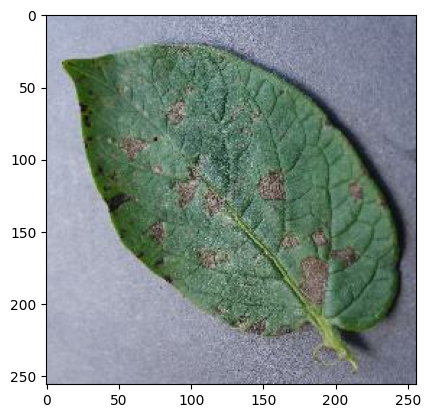

In [29]:
for image_batch, label_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print("First image label:", class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print("predicted label: ",class_names[np.argmax(batch_prediction[0])])


In [30]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


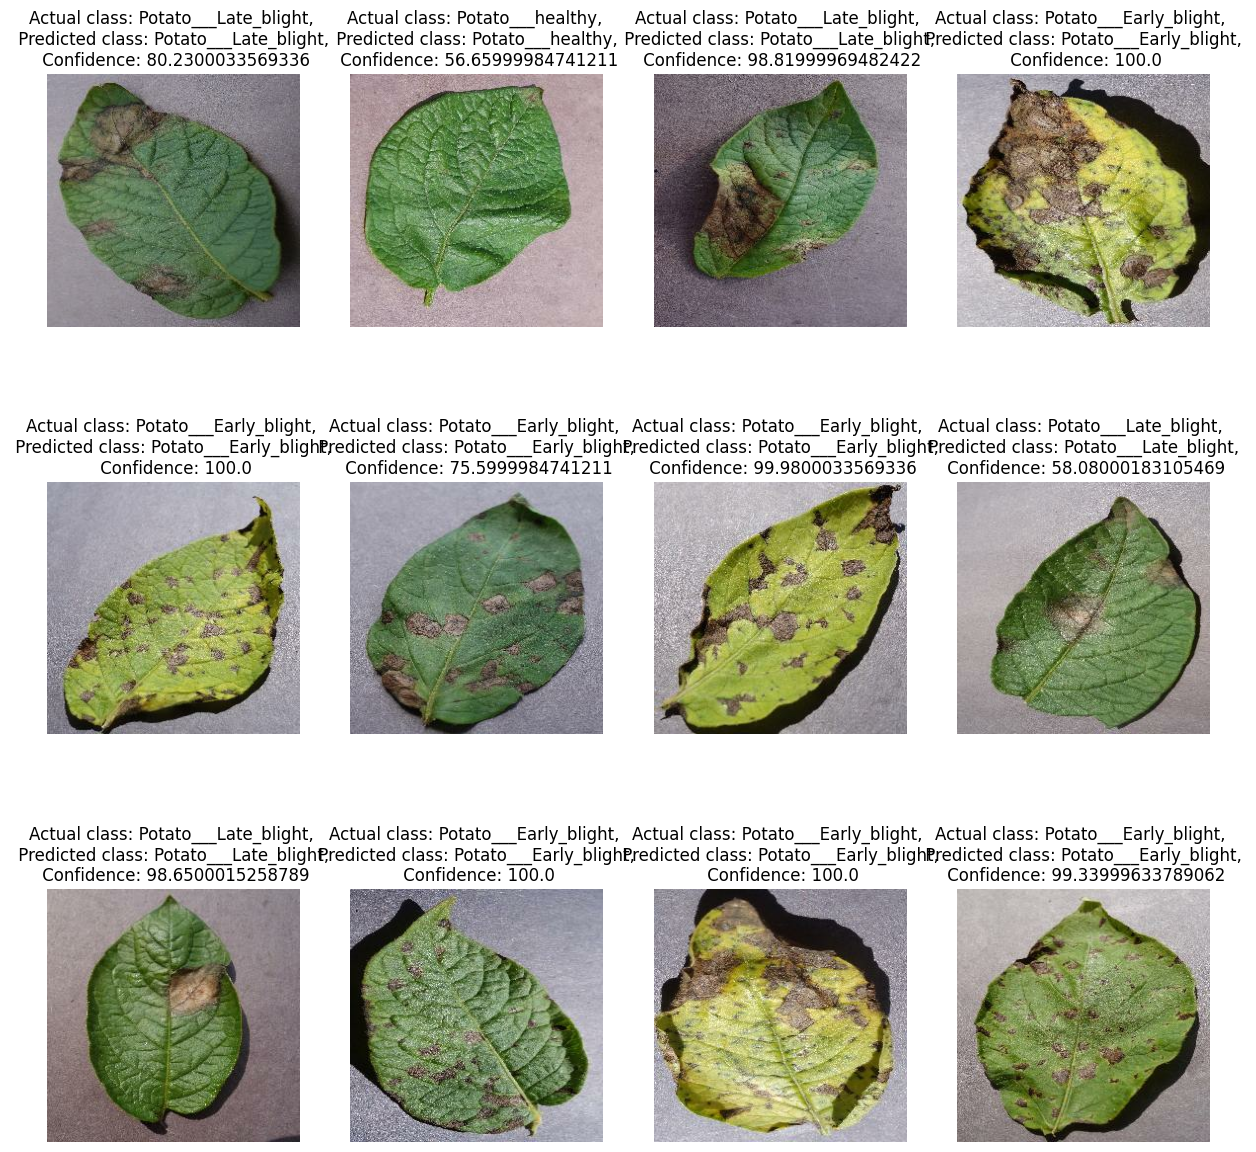

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual class: {actual_class}, \n Predicted class: {predicted_class}, \n Confidence: {confidence}")
    plt.axis("off")

In [38]:
model_version = 1
model.save(f"/content/drive/MyDrive/Datasets/models/CNN_model{model_version}.keras")